### Optimal control of phenomenological models, e.g. the model model
This notebook shows how to compute the optimal control (OC) signal for the model model for a simple example task. For the Hopf-model the OC can be computed completely analogously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
def getfinalstate(model):
    N = len(model.params.Cmat)
    V = len(model.state_vars)
    T = model.getMaxDelay()+1
    state = np.zeros((N, V, T))
    for n in range(N):
        for v in range(V):
            state[n,v,:] = model.state[model.state_vars[v]][n, -T:]
    return state

def setinitstate(model, state):
    N = len(model.params.Cmat)
    V = len(model.init_vars)
    T = model.getMaxDelay()+1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:,v,-T:]
            else:
                model.params[model.init_vars[v]] = state[:,v,-1]

    return

In [3]:
# We import the model
model = ALNModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 1000.

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
model.params.mue_ext_mean = 0.
model.run()

finalstate = getfinalstate(model)
setinitstate(model, finalstate)

duration = 10.
model.params["duration"] = duration
model.run()
amplitude = 1.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

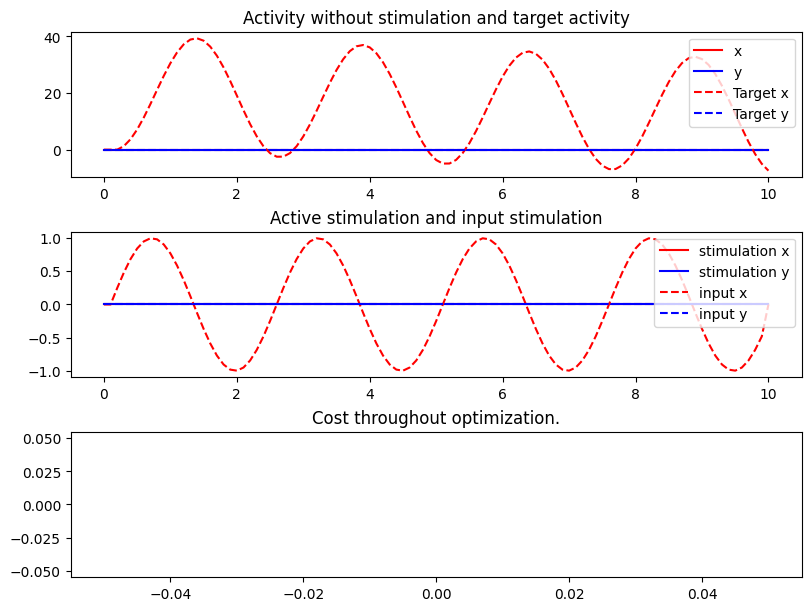

In [4]:
# We set the stimulus in x and y variables, and run the simulation
model.params["ext_exc_current"] = input
model.params["ext_inh_current"] = zero_input
model.run()

# Define the result of the stimulation as target
t0 = np.concatenate( (model.params["rates_exc_init"][:, np.newaxis, -1], model.params["rates_inh_init"][:, np.newaxis, -1]), axis=1)[:,:,np.newaxis]
t1 = np.stack( (model.rates_exc, model.rates_inh), axis=1)
target = np.concatenate((t0, t1), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
s0 = np.concatenate( (model.params["rates_exc_init"][:, np.newaxis, -1], model.params["rates_inh_init"][:, np.newaxis, -1]), axis=1)[:,:,np.newaxis]
s1 = np.stack( (model.rates_exc, model.rates_inh), axis=1)
state = np.concatenate((s0, s1), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 2270.379226436175
1 101 [[40]]
11
11
Final cost : 2270.379226436175


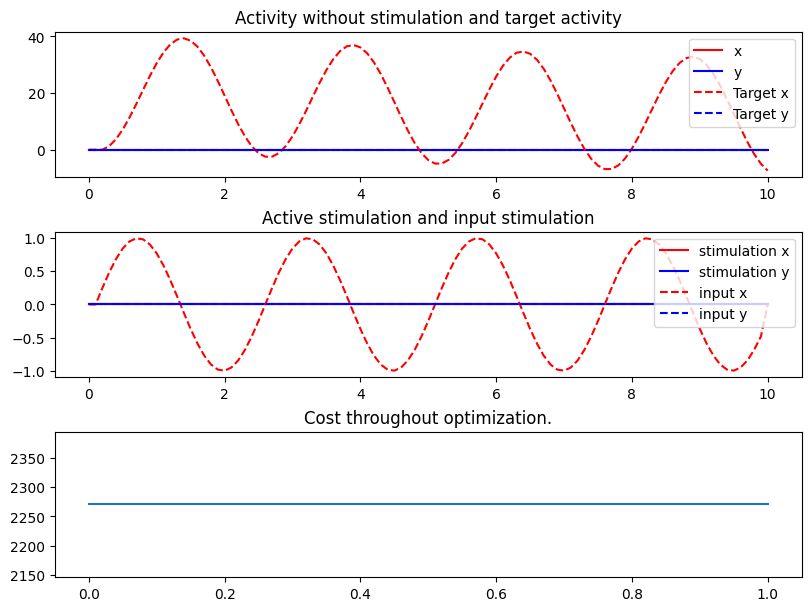

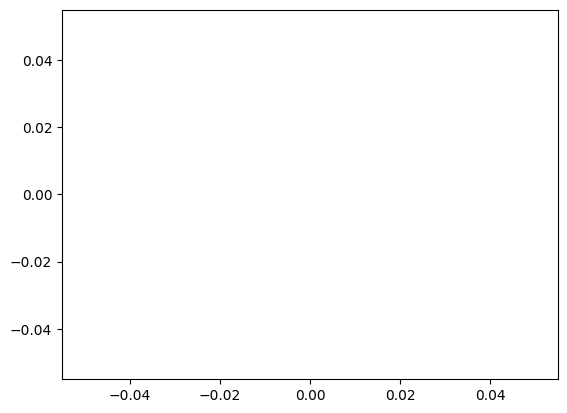

In [27]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25))

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(1)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()